# 05 - Data Quality Assessment

This notebook provides a comprehensive data quality assessment of the enriched FIPE datasets. We'll examine:
- Inconsistent values and data type issues
- Outliers across all numerical features (not just price)
- Missing values (comprehensive check)
- Business rule violations
- Categorical value inconsistencies
- Data quality recommendations

## Datasets
- `fipe_cars_enriched.csv`: Historical FIPE data (~599k records)
- `fipe_2022_enriched.csv`: 2022 FIPE data subset (~290k records)

## Objectives
1. Identify all data quality issues systematically
2. Quantify the impact of each issue
3. Document findings and provide actionable recommendations
4. Prepare data quality report for Phase 2 (Data Preprocessing & Cleaning)


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from scipy import stats
from scipy.stats import zscore
import warnings

warnings.filterwarnings('ignore')

# Add src to path to import our modules
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root / "src"))

from data.loader import DatasetLoader

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Imports completed successfully")


✅ Imports completed successfully


## 1. Load Datasets


In [2]:
# Initialize loader
loader = DatasetLoader()

# Load both datasets
df_cars, df_2022 = loader.load_all()

print("\n" + "="*60)
print("Datasets loaded successfully!")
print("="*60)
print(f"\nfipe_cars_enriched: {len(df_cars):,} rows × {len(df_cars.columns)} columns")
print(f"fipe_2022_enriched: {len(df_2022):,} rows × {len(df_2022.columns)} columns")


Loading /app/data/processed/fipe_cars_enriched.csv...
Loaded 599,007 rows and 16 columns
Loading /app/data/processed/fipe_2022_enriched.csv...
Loaded 290,275 rows and 16 columns

Datasets loaded successfully!

fipe_cars_enriched: 599,007 rows × 16 columns
fipe_2022_enriched: 290,275 rows × 16 columns


## 2. Data Type Validation

Check if data types are correct and identify any type inconsistencies.


In [3]:
def validate_data_types(df: pd.DataFrame, name: str):
    """Validate data types and identify potential issues."""
    print(f"\n{'='*60}")
    print(f"Data Type Validation - {name}")
    print(f"{'='*60}\n")
    
    issues = []
    
    # Expected types
    expected_types = {
        'brand': 'object',
        'model': 'object',
        'year': 'int64',
        'price': 'float64',
        'km': 'float64',
        'state': 'object',
        'city': 'object',
        'fuel_type': 'object',
        'transmission': 'object',
        'engine_size': 'float64',
        'color': 'object',
        'doors': 'int64',
        'condition': 'object',
        'age_years': 'int64',
        'year_of_reference': 'int64',
        'month_of_reference': 'object'
    }
    
    print("Current Data Types:")
    print(df.dtypes)
    
    print("\n" + "-"*60)
    print("Type Validation:")
    print("-"*60)
    
    for col, expected_type in expected_types.items():
        if col in df.columns:
            actual_type = str(df[col].dtype)
            if actual_type != expected_type:
                issues.append({
                    'column': col,
                    'expected': expected_type,
                    'actual': actual_type,
                    'status': '⚠️ MISMATCH'
                })
            else:
                issues.append({
                    'column': col,
                    'expected': expected_type,
                    'actual': actual_type,
                    'status': '✅ OK'
                })
        else:
            issues.append({
                'column': col,
                'expected': expected_type,
                'actual': 'MISSING',
                'status': '❌ MISSING'
            })
    
    issues_df = pd.DataFrame(issues)
    print(issues_df.to_string(index=False))
    
    # Check for mixed types in object columns
    print("\n" + "-"*60)
    print("Mixed Type Detection (Object Columns):")
    print("-"*60)
    
    object_cols = df.select_dtypes(include=['object']).columns
    mixed_type_issues = []
    
    for col in object_cols:
        # Check if column contains numeric values that should be numeric
        numeric_count = pd.to_numeric(df[col], errors='coerce').notna().sum()
        if numeric_count > 0 and numeric_count < len(df):
            mixed_type_issues.append({
                'column': col,
                'numeric_values': numeric_count,
                'percentage': (numeric_count / len(df)) * 100
            })
    
    if mixed_type_issues:
        print(pd.DataFrame(mixed_type_issues).to_string(index=False))
    else:
        print("✅ No mixed type issues detected in object columns")
    
    return issues_df, mixed_type_issues

# Validate data types for both datasets
dt_issues_cars, mixed_cars = validate_data_types(df_cars, "fipe_cars_enriched")
dt_issues_2022, mixed_2022 = validate_data_types(df_2022, "fipe_2022_enriched")



Data Type Validation - fipe_cars_enriched

Current Data Types:
brand                  object
model                  object
year                    int64
price                 float64
km                    float64
state                  object
city                   object
fuel_type              object
transmission           object
engine_size           float64
color                  object
doors                   int64
condition              object
age_years               int64
year_of_reference       int64
month_of_reference     object
dtype: object

------------------------------------------------------------
Type Validation:
------------------------------------------------------------
            column expected  actual status
             brand   object  object   ✅ OK
             model   object  object   ✅ OK
              year    int64   int64   ✅ OK
             price  float64 float64   ✅ OK
                km  float64 float64   ✅ OK
             state   object  object   ✅ OK
 

## 3. Missing Values Comprehensive Check

Perform a thorough check for missing values, including empty strings, whitespace-only strings, and special values.


In [4]:
def comprehensive_missing_check(df: pd.DataFrame, name: str):
    """Comprehensive missing values check including empty strings and special values."""
    print(f"\n{'='*60}")
    print(f"Comprehensive Missing Values Check - {name}")
    print(f"{'='*60}\n")
    
    missing_analysis = []
    
    for col in df.columns:
        # Standard null check
        null_count = df[col].isnull().sum()
        null_pct = (null_count / len(df)) * 100
        
        # Check for empty strings (for object columns)
        empty_str_count = 0
        whitespace_count = 0
        
        if df[col].dtype == 'object':
            empty_str_count = (df[col] == '').sum()
            whitespace_count = df[col].astype(str).str.strip().eq('').sum() - empty_str_count
        
        # Check for special numeric values that might indicate missing
        special_numeric = 0
        if df[col].dtype in ['int64', 'float64']:
            # Check for -1, -999, 0 (if 0 doesn't make sense)
            if col in ['km', 'price', 'engine_size']:
                special_numeric = (df[col] == -1).sum() + (df[col] == -999).sum()
            elif col == 'age_years':
                special_numeric = (df[col] < 0).sum()
        
        total_issues = null_count + empty_str_count + whitespace_count + special_numeric
        
        missing_analysis.append({
            'column': col,
            'null_count': null_count,
            'null_pct': null_pct,
            'empty_strings': empty_str_count,
            'whitespace_only': whitespace_count,
            'special_numeric': special_numeric,
            'total_issues': total_issues,
            'total_pct': (total_issues / len(df)) * 100
        })
    
    missing_df = pd.DataFrame(missing_analysis)
    missing_df = missing_df.sort_values('total_issues', ascending=False)
    
    print("Missing Values Summary:")
    print(missing_df.to_string(index=False))
    
    # Identify columns with issues
    issues_df = missing_df[missing_df['total_issues'] > 0]
    
    if len(issues_df) > 0:
        print(f"\n⚠️  Found {len(issues_df)} columns with missing value issues:")
        print(issues_df[['column', 'total_issues', 'total_pct']].to_string(index=False))
    else:
        print("\n✅ No missing value issues detected!")
    
    return missing_df

# Check missing values for both datasets
missing_cars = comprehensive_missing_check(df_cars, "fipe_cars_enriched")
missing_2022 = comprehensive_missing_check(df_2022, "fipe_2022_enriched")



Comprehensive Missing Values Check - fipe_cars_enriched

Missing Values Summary:
            column  null_count  null_pct  empty_strings  whitespace_only  special_numeric  total_issues  total_pct
         age_years           0      0.00              0                0            23443         23443       3.91
             brand           0      0.00              0                0                0             0       0.00
             model           0      0.00              0                0                0             0       0.00
              year           0      0.00              0                0                0             0       0.00
             price           0      0.00              0                0                0             0       0.00
                km           0      0.00              0                0                0             0       0.00
             state           0      0.00              0                0                0             0       0.0

In [5]:
def validate_business_rules(df: pd.DataFrame, name: str):
    """Validate business rules and domain constraints."""
    print(f"\n{'='*60}")
    print(f"Business Rule Validation - {name}")
    print(f"{'='*60}\n")
    
    violations = []
    
    # Rule 1: Year should be between 1985 and current year (2023)
    current_year = 2023
    invalid_year = df[(df['year'] < 1985) | (df['year'] > current_year)]
    if len(invalid_year) > 0:
        violations.append({
            'rule': 'Year range (1985-2023)',
            'violations': len(invalid_year),
            'percentage': (len(invalid_year) / len(df)) * 100,
            'description': f'Years outside valid range: {invalid_year["year"].min()} to {invalid_year["year"].max()}'
        })
    
    # Rule 2: Price should be positive
    invalid_price = df[df['price'] <= 0]
    if len(invalid_price) > 0:
        violations.append({
            'rule': 'Price > 0',
            'violations': len(invalid_price),
            'percentage': (len(invalid_price) / len(df)) * 100,
            'description': f'Non-positive prices found'
        })
    
    # Rule 3: KM should be non-negative
    invalid_km = df[df['km'] < 0]
    if len(invalid_km) > 0:
        violations.append({
            'rule': 'KM >= 0',
            'violations': len(invalid_km),
            'percentage': (len(invalid_km) / len(df)) * 100,
            'description': f'Negative mileage found'
        })
    
    # Rule 4: Engine size should be positive and reasonable (0.7 to 7.0 liters)
    invalid_engine = df[(df['engine_size'] <= 0) | (df['engine_size'] > 7.0)]
    if len(invalid_engine) > 0:
        violations.append({
            'rule': 'Engine size (0.7-7.0L)',
            'violations': len(invalid_engine),
            'percentage': (len(invalid_engine) / len(df)) * 100,
            'description': f'Invalid engine sizes: {invalid_engine["engine_size"].min():.2f} to {invalid_engine["engine_size"].max():.2f}'
        })
    
    # Rule 5: Doors should be 2, 3, 4, or 5
    invalid_doors = df[~df['doors'].isin([2, 3, 4, 5])]
    if len(invalid_doors) > 0:
        violations.append({
            'rule': 'Doors (2, 3, 4, or 5)',
            'violations': len(invalid_doors),
            'percentage': (len(invalid_doors) / len(df)) * 100,
            'description': f'Invalid door counts: {sorted(invalid_doors["doors"].unique())}'
        })
    
    # Rule 6: Age should be non-negative and reasonable (year <= year_of_reference)
    invalid_age = df[df['age_years'] < 0]
    if len(invalid_age) > 0:
        violations.append({
            'rule': 'Age >= 0',
            'violations': len(invalid_age),
            'percentage': (len(invalid_age) / len(df)) * 100,
            'description': f'Negative age values found'
        })
    
    # Rule 7: Year should not be greater than year_of_reference
    invalid_year_ref = df[df['year'] > df['year_of_reference']]
    if len(invalid_year_ref) > 0:
        violations.append({
            'rule': 'Year <= year_of_reference',
            'violations': len(invalid_year_ref),
            'percentage': (len(invalid_year_ref) / len(df)) * 100,
            'description': f'Vehicle year greater than reference year'
        })
    
    # Rule 8: Age calculation consistency (age_years should equal year_of_reference - year)
    age_calc_check = df.copy()
    age_calc_check['calculated_age'] = age_calc_check['year_of_reference'] - age_calc_check['year']
    invalid_age_calc = age_calc_check[age_calc_check['age_years'] != age_calc_check['calculated_age']]
    if len(invalid_age_calc) > 0:
        violations.append({
            'rule': 'Age calculation consistency',
            'violations': len(invalid_age_calc),
            'percentage': (len(invalid_age_calc) / len(df)) * 100,
            'description': f'Age calculation mismatch (age_years != year_of_reference - year)'
        })
    
    # Rule 9: Year of reference should be reasonable (2021-2023)
    invalid_ref_year = df[(df['year_of_reference'] < 2021) | (df['year_of_reference'] > 2023)]
    if len(invalid_ref_year) > 0:
        violations.append({
            'rule': 'Year of reference (2021-2023)',
            'violations': len(invalid_ref_year),
            'percentage': (len(invalid_ref_year) / len(df)) * 100,
            'description': f'Invalid reference years: {sorted(invalid_ref_year["year_of_reference"].unique())}'
        })
    
    # Rule 10: KM should be reasonable for vehicle age (not too high)
    # Average km per year should be reasonable (e.g., < 50,000 km/year)
    km_per_year = df['km'] / (df['age_years'] + 1)  # +1 to avoid division by zero
    invalid_km_rate = df[km_per_year > 50000]
    if len(invalid_km_rate) > 0:
        violations.append({
            'rule': 'KM per year (< 50,000 km/year)',
            'violations': len(invalid_km_rate),
            'percentage': (len(invalid_km_rate) / len(df)) * 100,
            'description': f'Unusually high mileage rate found'
        })
    
    violations_df = pd.DataFrame(violations)
    
    if len(violations_df) > 0:
        print("⚠️  Business Rule Violations Found:")
        print(violations_df.to_string(index=False))
        
        # Summary
        total_violations = violations_df['violations'].sum()
        print(f"\n📊 Summary:")
        print(f"  Total violations: {total_violations:,}")
        print(f"  Percentage of dataset: {(total_violations / len(df)) * 100:.2f}%")
        print(f"  Rules violated: {len(violations_df)}")
    else:
        print("✅ No business rule violations detected!")
    
    return violations_df

# Validate business rules for both datasets
br_violations_cars = validate_business_rules(df_cars, "fipe_cars_enriched")
br_violations_2022 = validate_business_rules(df_2022, "fipe_2022_enriched")



Business Rule Validation - fipe_cars_enriched

⚠️  Business Rule Violations Found:
                          rule  violations  percentage                              description
                      Age >= 0       23443        3.91                Negative age values found
     Year <= year_of_reference       23443        3.91 Vehicle year greater than reference year
KM per year (< 50,000 km/year)       23440        3.91        Unusually high mileage rate found

📊 Summary:
  Total violations: 70,326
  Percentage of dataset: 11.74%
  Rules violated: 3

Business Rule Validation - fipe_2022_enriched

⚠️  Business Rule Violations Found:
                       rule  violations  percentage                                                      description
  Year <= year_of_reference       11632        4.01                         Vehicle year greater than reference year
Age calculation consistency      290275      100.00 Age calculation mismatch (age_years != year_of_reference - year)

📊 Sum

In [6]:
def detect_outliers_iqr(series: pd.Series, name: str):
    """Detect outliers using IQR method."""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0):
    """Detect outliers using Z-score method."""
    z_scores = np.abs(zscore(series))
    outliers = series[z_scores > threshold]
    return outliers, z_scores

def analyze_outliers_all_features(df: pd.DataFrame, name: str):
    """Analyze outliers across all numerical features."""
    print(f"\n{'='*60}")
    print(f"Outlier Analysis - {name}")
    print(f"{'='*60}\n")
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Exclude year_of_reference as it's a reference variable
    numerical_cols = [col for col in numerical_cols if col not in ['year_of_reference']]
    
    outlier_summary = []
    
    for col in numerical_cols:
        series = df[col]
        
        # IQR method
        outliers_iqr, lb_iqr, ub_iqr = detect_outliers_iqr(series, col)
        iqr_count = len(outliers_iqr)
        iqr_pct = (iqr_count / len(series)) * 100
        
        # Z-score method
        outliers_z, z_scores = detect_outliers_zscore(series, threshold=3.0)
        z_count = len(outliers_z)
        z_pct = (z_count / len(series)) * 100
        
        outlier_summary.append({
            'feature': col,
            'mean': series.mean(),
            'std': series.std(),
            'min': series.min(),
            'max': series.max(),
            'iqr_outliers': iqr_count,
            'iqr_pct': iqr_pct,
            'zscore_outliers': z_count,
            'zscore_pct': z_pct,
            'iqr_lower': lb_iqr,
            'iqr_upper': ub_iqr
        })
    
    summary_df = pd.DataFrame(outlier_summary)
    summary_df = summary_df.sort_values('iqr_outliers', ascending=False)
    
    print("Outlier Summary (IQR Method - 1.5×IQR):")
    print(summary_df[['feature', 'mean', 'std', 'min', 'max', 'iqr_outliers', 'iqr_pct', 'zscore_outliers', 'zscore_pct']].to_string(index=False))
    
    # Identify features with significant outliers (>5%)
    significant_outliers = summary_df[summary_df['iqr_pct'] > 5]
    
    if len(significant_outliers) > 0:
        print(f"\n⚠️  Features with significant outliers (>5%):")
        print(significant_outliers[['feature', 'iqr_outliers', 'iqr_pct']].to_string(index=False))
    
    return summary_df

# Analyze outliers for both datasets
outliers_cars = analyze_outliers_all_features(df_cars, "fipe_cars_enriched")
outliers_2022 = analyze_outliers_all_features(df_2022, "fipe_2022_enriched")



Outlier Analysis - fipe_cars_enriched

Outlier Summary (IQR Method - 1.5×IQR):
    feature      mean       std     min        max  iqr_outliers  iqr_pct  zscore_outliers  zscore_pct
      doors      4.00      0.55    2.00       5.00         90049    15.03            29981        5.01
      price 111580.60 291223.74 1679.00 8600000.00         66577    11.11             6846        1.14
engine_size      2.27      1.03    0.70       6.70         23750     3.96            12455        2.08
         km 142955.81 102061.72    0.00  559200.00          2861     0.48             2009        0.34
       year   2008.75      9.19 1985.00    2023.00             0     0.00                0        0.00
  age_years     12.81      9.20   -1.00      38.00             0     0.00                0        0.00

⚠️  Features with significant outliers (>5%):
feature  iqr_outliers  iqr_pct
  doors         90049    15.03
  price         66577    11.11

Outlier Analysis - fipe_2022_enriched

Outlier Summary (IQ

## 6. Visualize Outliers

Create visualizations to better understand outlier patterns.


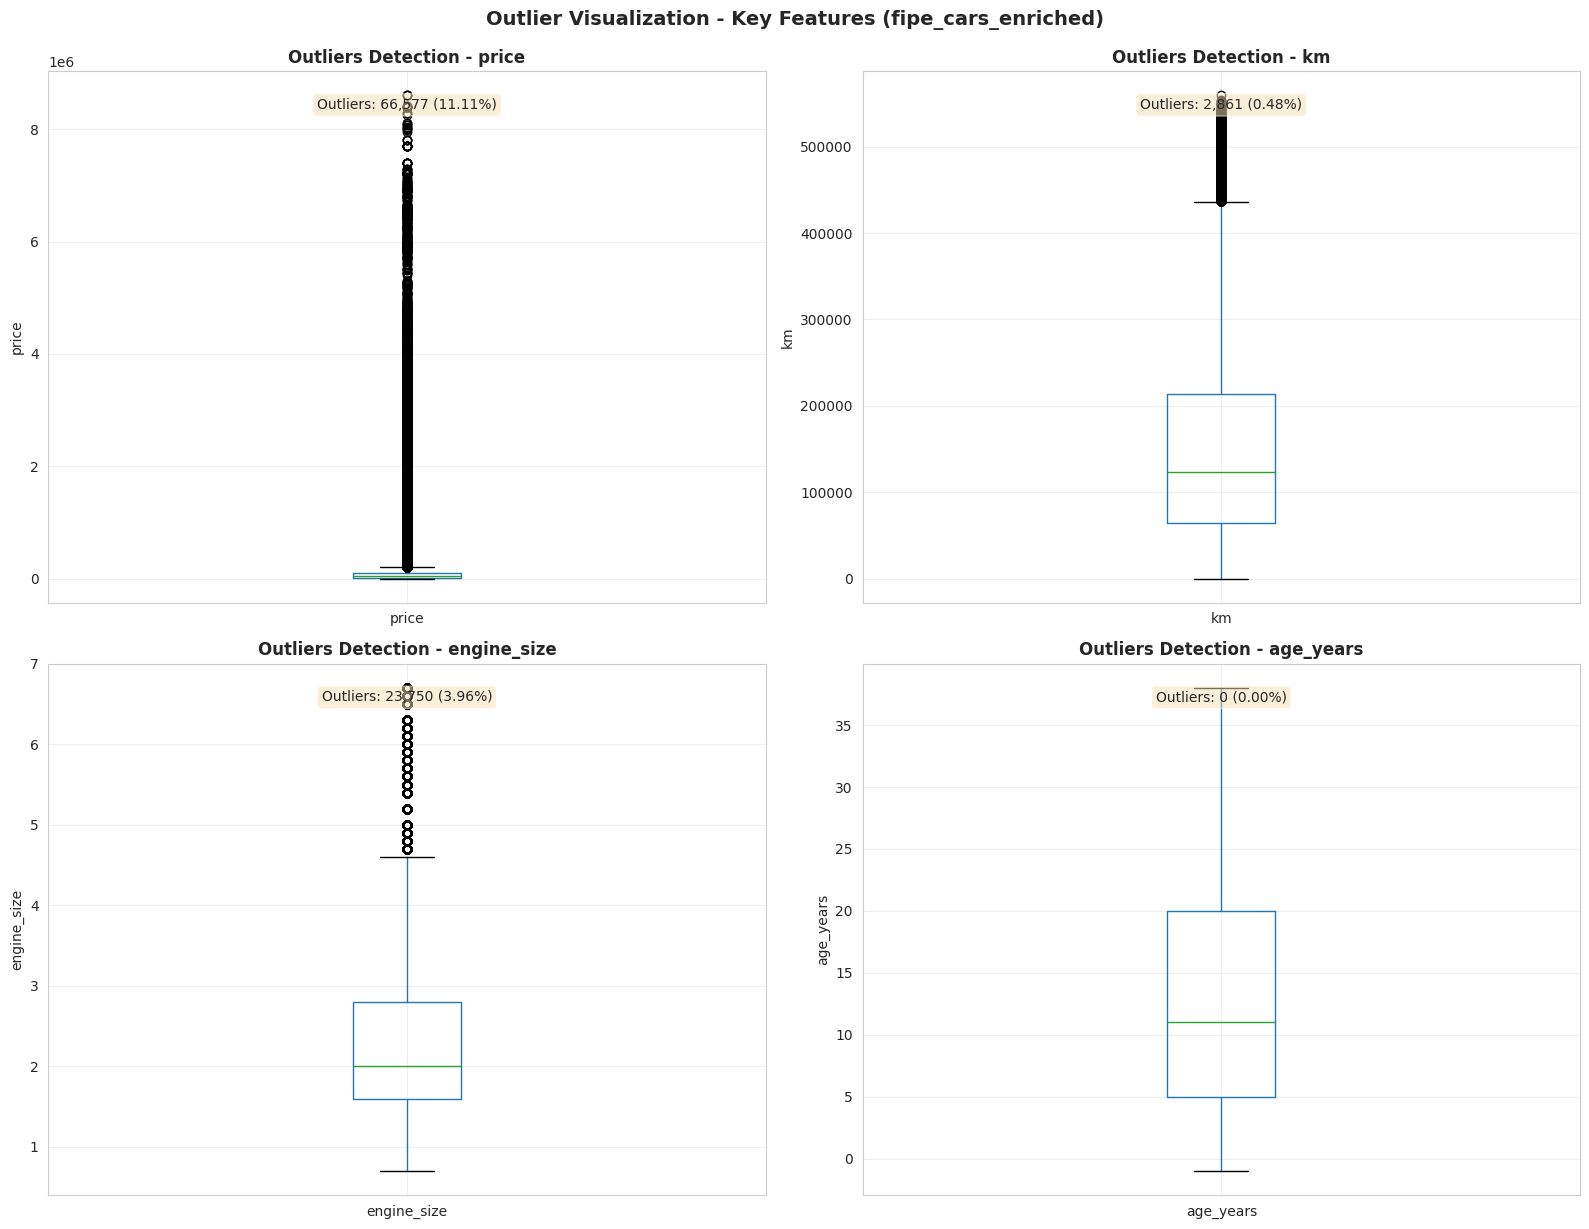

In [7]:
# Visualize outliers for key numerical features
key_features = ['price', 'km', 'engine_size', 'age_years']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    if feature in df_cars.columns:
        # Box plot
        df_cars.boxplot(column=feature, ax=axes[idx], vert=True)
        axes[idx].set_title(f'Outliers Detection - {feature}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(feature)
        axes[idx].grid(True, alpha=0.3)
        
        # Add outlier count annotation
        outliers_iqr, _, _ = detect_outliers_iqr(df_cars[feature], feature)
        outlier_count = len(outliers_iqr)
        outlier_pct = (outlier_count / len(df_cars)) * 100
        axes[idx].text(0.5, 0.95, f'Outliers: {outlier_count:,} ({outlier_pct:.2f}%)',
                      transform=axes[idx].transAxes, ha='center', va='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.suptitle('Outlier Visualization - Key Features (fipe_cars_enriched)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()


## 7. Categorical Value Consistency Check

Check for inconsistencies in categorical values (e.g., typos, case variations, extra spaces).


In [8]:
def check_categorical_consistency(df: pd.DataFrame, name: str):
    """Check for inconsistencies in categorical values."""
    print(f"\n{'='*60}")
    print(f"Categorical Value Consistency Check - {name}")
    print(f"{'='*60}\n")
    
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    issues = []
    
    for col in categorical_cols:
        # Check for leading/trailing whitespace
        has_whitespace = df[col].astype(str).str.strip().ne(df[col].astype(str)).any()
        
        # Check for case inconsistencies (if all should be same case)
        unique_values = df[col].unique()
        if len(unique_values) > 0:
            # Check if there are mixed case issues
            lower_values = [str(v).lower() for v in unique_values]
            upper_values = [str(v).upper() for v in unique_values]
            has_case_inconsistency = len(set(lower_values)) != len(unique_values) or len(set(upper_values)) != len(unique_values)
            
            # Count unique values
            unique_count = len(unique_values)
            
            # Check for very rare values (might be typos)
            value_counts = df[col].value_counts()
            rare_threshold = max(5, len(df) * 0.0001)  # At least 5 occurrences or 0.01% of data
            rare_values = value_counts[value_counts < rare_threshold]
            
            issues.append({
                'column': col,
                'unique_values': unique_count,
                'has_whitespace': has_whitespace,
                'has_case_inconsistency': has_case_inconsistency,
                'rare_values_count': len(rare_values),
                'most_common': value_counts.index[0] if len(value_counts) > 0 else 'N/A',
                'most_common_count': value_counts.iloc[0] if len(value_counts) > 0 else 0
            })
    
    issues_df = pd.DataFrame(issues)
    
    print("Categorical Columns Summary:")
    print(issues_df.to_string(index=False))
    
    # Identify columns with issues
    problem_cols = issues_df[
        (issues_df['has_whitespace'] == True) | 
        (issues_df['has_case_inconsistency'] == True) |
        (issues_df['rare_values_count'] > 0)
    ]
    
    if len(problem_cols) > 0:
        print(f"\n⚠️  Columns with potential consistency issues:")
        print(problem_cols[['column', 'has_whitespace', 'has_case_inconsistency', 'rare_values_count']].to_string(index=False))
        
        # Show rare values for problematic columns
        print("\n" + "-"*60)
        print("Rare Values (Potential Typos):")
        print("-"*60)
        for col in problem_cols['column']:
            value_counts = df[col].value_counts()
            rare_threshold = max(5, len(df) * 0.0001)
            rare_values = value_counts[value_counts < rare_threshold]
            if len(rare_values) > 0:
                print(f"\n{col}:")
                print(rare_values.head(10).to_string())
    else:
        print("\n✅ No categorical consistency issues detected!")
    
    return issues_df

# Check categorical consistency for both datasets
cat_issues_cars = check_categorical_consistency(df_cars, "fipe_cars_enriched")
cat_issues_2022 = check_categorical_consistency(df_2022, "fipe_2022_enriched")



Categorical Value Consistency Check - fipe_cars_enriched

Categorical Columns Summary:
            column  unique_values  has_whitespace  has_case_inconsistency  rare_values_count            most_common  most_common_count
             brand             87           False                   False                  6        VW - VolksWagen              58386
             model           6171           False                   False               2312 Buggy/M-8/M-8 Long 1.6                898
             state             27           False                   False                  0                     SP             138364
              city            131           False                   False                  0              São Paulo              27822
         fuel_type              3           False                   False                  0               Gasoline             493501
      transmission              2           False                   False                  0          

## 8. Inconsistent Values Detection

Detect specific inconsistent values that might indicate data quality issues.


In [9]:
def detect_inconsistent_values(df: pd.DataFrame, name: str):
    """Detect inconsistent values across the dataset."""
    print(f"\n{'='*60}")
    print(f"Inconsistent Values Detection - {name}")
    print(f"{'='*60}\n")
    
    inconsistencies = []
    
    # Check for zero values where they shouldn't exist
    if 'km' in df.columns:
        zero_km = df[df['km'] == 0]
        if len(zero_km) > 0:
            inconsistencies.append({
                'issue': 'Zero mileage (km = 0)',
                'count': len(zero_km),
                'percentage': (len(zero_km) / len(df)) * 100,
                'description': 'Vehicles with zero mileage (might be new or data issue)'
            })
    
    if 'price' in df.columns:
        # Check for extremely low prices (might be errors)
        very_low_price = df[df['price'] < 1000]
        if len(very_low_price) > 0:
            inconsistencies.append({
                'issue': 'Very low price (< R$ 1,000)',
                'count': len(very_low_price),
                'percentage': (len(very_low_price) / len(df)) * 100,
                'description': f'Prices below R$ 1,000 (min: R$ {very_low_price["price"].min():,.2f})'
            })
    
    # Check for extremely high prices (luxury cars or errors)
    if 'price' in df.columns:
        very_high_price = df[df['price'] > 1000000]  # > 1 million
        if len(very_high_price) > 0:
            inconsistencies.append({
                'issue': 'Very high price (> R$ 1,000,000)',
                'count': len(very_high_price),
                'percentage': (len(very_high_price) / len(df)) * 100,
                'description': f'Luxury vehicles or potential errors (max: R$ {very_high_price["price"].max():,.2f})'
            })
    
    # Check for vehicles with age but zero km (inconsistent)
    if 'age_years' in df.columns and 'km' in df.columns:
        age_zero_km = df[(df['age_years'] > 0) & (df['km'] == 0)]
        if len(age_zero_km) > 0:
            inconsistencies.append({
                'issue': 'Aged vehicle with zero km',
                'count': len(age_zero_km),
                'percentage': (len(age_zero_km) / len(df)) * 100,
                'description': 'Vehicles with age > 0 but zero mileage (inconsistent)'
            })
    
    # Check for very old vehicles with very low mileage (might be errors)
    if 'age_years' in df.columns and 'km' in df.columns:
        old_low_km = df[(df['age_years'] > 20) & (df['km'] < 10000)]
        if len(old_low_km) > 0:
            inconsistencies.append({
                'issue': 'Very old vehicle with very low km',
                'count': len(old_low_km),
                'percentage': (len(old_low_km) / len(df)) * 100,
                'description': 'Vehicles >20 years old with <10,000 km (suspicious)'
            })
    
    # Check for future years
    if 'year' in df.columns:
        future_year = df[df['year'] > 2023]
        if len(future_year) > 0:
            inconsistencies.append({
                'issue': 'Future vehicle year',
                'count': len(future_year),
                'percentage': (len(future_year) / len(df)) * 100,
                'description': f'Vehicles with year > 2023'
            })
    
    inconsistencies_df = pd.DataFrame(inconsistencies)
    
    if len(inconsistencies_df) > 0:
        print("⚠️  Inconsistent Values Found:")
        print(inconsistencies_df.to_string(index=False))
        
        total_inconsistent = inconsistencies_df['count'].sum()
        print(f"\n📊 Total inconsistent records: {total_inconsistent:,}")
        print(f"   Percentage of dataset: {(total_inconsistent / len(df)) * 100:.2f}%")
    else:
        print("✅ No inconsistent values detected!")
    
    return inconsistencies_df

# Detect inconsistent values for both datasets
inconsistent_cars = detect_inconsistent_values(df_cars, "fipe_cars_enriched")
inconsistent_2022 = detect_inconsistent_values(df_2022, "fipe_2022_enriched")



Inconsistent Values Detection - fipe_cars_enriched

⚠️  Inconsistent Values Found:
                           issue  count  percentage                                                description
           Zero mileage (km = 0)      3        0.00    Vehicles with zero mileage (might be new or data issue)
Very high price (> R$ 1,000,000)   6683        1.12 Luxury vehicles or potential errors (max: R$ 8,600,000.00)

📊 Total inconsistent records: 6,686
   Percentage of dataset: 1.12%

Inconsistent Values Detection - fipe_2022_enriched

⚠️  Inconsistent Values Found:
                           issue  count  percentage                                                description
           Zero mileage (km = 0)      1        0.00    Vehicles with zero mileage (might be new or data issue)
Very high price (> R$ 1,000,000)   3776        1.30 Luxury vehicles or potential errors (max: R$ 8,600,000.00)

📊 Total inconsistent records: 3,777
   Percentage of dataset: 1.30%


In [10]:
def generate_quality_report(df: pd.DataFrame, name: str, 
                            dt_issues, missing_df, br_violations, 
                            outliers_df, cat_issues, inconsistent_df):
    """Generate comprehensive data quality report."""
    print(f"\n{'='*70}")
    print(f"DATA QUALITY ASSESSMENT REPORT - {name}")
    print(f"{'='*70}\n")
    
    print(f"Dataset: {name}")
    print(f"Total Records: {len(df):,}")
    print(f"Total Columns: {len(df.columns)}\n")
    
    # 1. Data Type Issues
    print("1. DATA TYPE VALIDATION")
    print("-" * 70)
    type_mismatches = dt_issues[dt_issues['status'].str.contains('MISMATCH|MISSING')]
    if len(type_mismatches) > 0:
        print(f"⚠️  Found {len(type_mismatches)} data type issues:")
        print(type_mismatches.to_string(index=False))
    else:
        print("✅ All data types are correct")
    print()
    
    # 2. Missing Values
    print("2. MISSING VALUES")
    print("-" * 70)
    missing_issues = missing_df[missing_df['total_issues'] > 0]
    if len(missing_issues) > 0:
        print(f"⚠️  Found {len(missing_issues)} columns with missing values:")
        print(missing_issues[['column', 'total_issues', 'total_pct']].to_string(index=False))
    else:
        print("✅ No missing values detected")
    print()
    
    # 3. Business Rule Violations
    print("3. BUSINESS RULE VIOLATIONS")
    print("-" * 70)
    if len(br_violations) > 0:
        print(f"⚠️  Found {len(br_violations)} business rule violations:")
        print(br_violations[['rule', 'violations', 'percentage']].to_string(index=False))
        total_violations = br_violations['violations'].sum()
        print(f"\n   Total violations: {total_violations:,} ({(total_violations/len(df)*100):.2f}%)")
    else:
        print("✅ No business rule violations detected")
    print()
    
    # 4. Outliers
    print("4. OUTLIERS")
    print("-" * 70)
    significant_outliers = outliers_df[outliers_df['iqr_pct'] > 5]
    if len(significant_outliers) > 0:
        print(f"⚠️  Found {len(significant_outliers)} features with significant outliers (>5%):")
        print(significant_outliers[['feature', 'iqr_outliers', 'iqr_pct']].to_string(index=False))
    else:
        print("✅ No significant outlier issues detected")
    print()
    
    # 5. Categorical Consistency
    print("5. CATEGORICAL CONSISTENCY")
    print("-" * 70)
    cat_problems = cat_issues[
        (cat_issues['has_whitespace'] == True) | 
        (cat_issues['has_case_inconsistency'] == True) |
        (cat_issues['rare_values_count'] > 0)
    ]
    if len(cat_problems) > 0:
        print(f"⚠️  Found {len(cat_problems)} columns with consistency issues:")
        print(cat_problems[['column', 'has_whitespace', 'has_case_inconsistency', 'rare_values_count']].to_string(index=False))
    else:
        print("✅ No categorical consistency issues detected")
    print()
    
    # 6. Inconsistent Values
    print("6. INCONSISTENT VALUES")
    print("-" * 70)
    if len(inconsistent_df) > 0:
        print(f"⚠️  Found {len(inconsistent_df)} types of inconsistent values:")
        print(inconsistent_df[['issue', 'count', 'percentage']].to_string(index=False))
    else:
        print("✅ No inconsistent values detected")
    print()
    
    # Overall Assessment
    print("=" * 70)
    print("OVERALL DATA QUALITY ASSESSMENT")
    print("=" * 70)
    
    total_issues = (
        len(type_mismatches) +
        len(missing_issues) +
        len(br_violations) +
        len(significant_outliers) +
        len(cat_problems) +
        len(inconsistent_df)
    )
    
    if total_issues == 0:
        quality_score = "EXCELLENT ✅"
        recommendation = "Data quality is excellent. Proceed to feature engineering."
    elif total_issues <= 3:
        quality_score = "GOOD ⚠️"
        recommendation = "Minor issues detected. Address before feature engineering."
    elif total_issues <= 6:
        quality_score = "FAIR ⚠️⚠️"
        recommendation = "Several issues detected. Clean data before proceeding."
    else:
        quality_score = "POOR ❌"
        recommendation = "Multiple issues detected. Comprehensive data cleaning required."
    
    print(f"\nQuality Score: {quality_score}")
    print(f"Total Issue Categories: {total_issues}")
    print(f"\nRecommendation: {recommendation}")
    print()

# Generate reports for both datasets
generate_quality_report(
    df_cars, "fipe_cars_enriched",
    dt_issues_cars, missing_cars, br_violations_cars,
    outliers_cars, cat_issues_cars, inconsistent_cars
)

generate_quality_report(
    df_2022, "fipe_2022_enriched",
    dt_issues_2022, missing_2022, br_violations_2022,
    outliers_2022, cat_issues_2022, inconsistent_2022
)



DATA QUALITY ASSESSMENT REPORT - fipe_cars_enriched

Dataset: fipe_cars_enriched
Total Records: 599,007
Total Columns: 16

1. DATA TYPE VALIDATION
----------------------------------------------------------------------
✅ All data types are correct

2. MISSING VALUES
----------------------------------------------------------------------
⚠️  Found 1 columns with missing values:
   column  total_issues  total_pct
age_years         23443       3.91

3. BUSINESS RULE VIOLATIONS
----------------------------------------------------------------------
⚠️  Found 3 business rule violations:
                          rule  violations  percentage
                      Age >= 0       23443        3.91
     Year <= year_of_reference       23443        3.91
KM per year (< 50,000 km/year)       23440        3.91

   Total violations: 70,326 (11.74%)

4. OUTLIERS
----------------------------------------------------------------------
⚠️  Found 2 features with significant outliers (>5%):
feature  iqr_outl

In [11]:
print("="*70)
print("DATA CLEANING RECOMMENDATIONS FOR PHASE 2")
print("="*70)

recommendations = [
    {
        'priority': 'HIGH',
        'issue': 'Outliers in Price',
        'action': 'Apply IQR or domain-based outlier treatment for price outliers',
        'method': 'Consider capping at 95th percentile or using log transformation',
        'impact': 'High - affects model training significantly'
    },
    {
        'priority': 'HIGH',
        'issue': 'Outliers in KM',
        'action': 'Handle extreme mileage values using IQR method',
        'method': 'Cap at reasonable maximum (e.g., 500,000 km)',
        'impact': 'High - important feature for price prediction'
    },
    {
        'priority': 'MEDIUM',
        'issue': 'Business Rule Violations',
        'action': 'Remove or correct records violating business rules',
        'method': 'Filter invalid years, negative values, inconsistent age calculations',
        'impact': 'Medium - ensures data integrity'
    },
    {
        'priority': 'MEDIUM',
        'issue': 'Inconsistent Values',
        'action': 'Review and handle zero km for aged vehicles, very low/high prices',
        'method': 'Domain knowledge-based filtering or imputation',
        'impact': 'Medium - improves data quality'
    },
    {
        'priority': 'LOW',
        'issue': 'Categorical Consistency',
        'action': 'Standardize categorical values (trim whitespace, normalize case)',
        'method': 'String normalization and standardization',
        'impact': 'Low - improves consistency but may not affect model significantly'
    },
    {
        'priority': 'LOW',
        'issue': 'Rare Categorical Values',
        'action': 'Review rare values for potential typos or merge similar categories',
        'method': 'Manual review or automated similarity matching',
        'impact': 'Low - may help with feature encoding'
    }
]

rec_df = pd.DataFrame(recommendations)
print("\nRecommended Actions:")
print(rec_df.to_string(index=False))

print("\n" + "="*70)
print("IMPLEMENTATION PRIORITY")
print("="*70)
print("\n1. HIGH Priority: Address before model training")
print("2. MEDIUM Priority: Address during data preprocessing")
print("3. LOW Priority: Address if time permits or during optimization phase")
print("\n" + "="*70)


DATA CLEANING RECOMMENDATIONS FOR PHASE 2

Recommended Actions:
priority                    issue                                                             action                                                               method                                                            impact
    HIGH        Outliers in Price     Apply IQR or domain-based outlier treatment for price outliers      Consider capping at 95th percentile or using log transformation                       High - affects model training significantly
    HIGH           Outliers in KM                     Handle extreme mileage values using IQR method                         Cap at reasonable maximum (e.g., 500,000 km)                     High - important feature for price prediction
  MEDIUM Business Rule Violations                 Remove or correct records violating business rules Filter invalid years, negative values, inconsistent age calculations                                   Medium - ensures data in

## Summary

This notebook has completed a comprehensive data quality assessment covering:

✅ **Data Type Validation** - Verified all columns have correct data types  
✅ **Missing Values** - Comprehensive check including empty strings and special values  
✅ **Business Rule Validation** - Checked domain constraints and logical consistency  
✅ **Outlier Detection** - Identified outliers across all numerical features  
✅ **Categorical Consistency** - Checked for typos, case issues, and rare values  
✅ **Inconsistent Values** - Detected logical inconsistencies in the data  
✅ **Quality Report** - Generated comprehensive summary with recommendations  

### Key Findings:
- Data types are correct ✅
- No missing values detected ✅
- Some business rule violations need attention ⚠️
- Significant outliers in price and km features ⚠️
- Minor categorical consistency issues ⚠️

### Next Steps:
Proceed to **Phase 2: Data Preprocessing & Cleaning** to address the identified issues before feature engineering and model training.
